In [1]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset


class CellTrackingDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]))
        msk = np.array(Image.open(self.mask_paths[idx]))

        if len(img.shape) == 2:
            img = img[..., np.newaxis]

        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
        msk = torch.from_numpy(msk > 0).float().unsqueeze(0)  # Binariser: 0 = background, 1 = cellule

        if self.transform:
            img = self.transform(img)
            msk = self.transform(msk)

        return img, msk


In [2]:
import glob

image_paths = sorted(glob.glob("data/images/*.tif"))
mask_paths = sorted(glob.glob("data/masks/*.tif"))

In [3]:
dataset = CellTrackingDataset(image_paths, mask_paths)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-20, 20])

In [7]:
mask1 = dataset[0][1]

In [8]:
print(mask1.min().item(), mask1.max().item(), mask1.unique()[:5])


0.0 1.0 tensor([0., 1.])


In [9]:
import matplotlib.pyplot as plt
im1 = dataset[0][0]

In [11]:
from torch.utils.data import Subset
import numpy as np

def frac_ones(ds, k=50):
    idx = np.random.choice(len(ds), size=min(k, len(ds)), replace=False)
    fracs = []
    for i in idx:
        _, m = ds[i]            # m: [1,H,W] ou [H,W]
        m = m.float()
        if m.ndim == 3: m = m[0]
        fracs.append(m.mean().item())
    return np.mean(fracs), np.min(fracs), np.max(fracs)

mean1, min1, max1 = frac_ones(dataset, k=100)
print(f"mask: frac(1) mean={mean1:.3f}  min={min1:.3f}  max={max1:.3f}")


mask: frac(1) mean=0.056  min=0.001  max=0.091


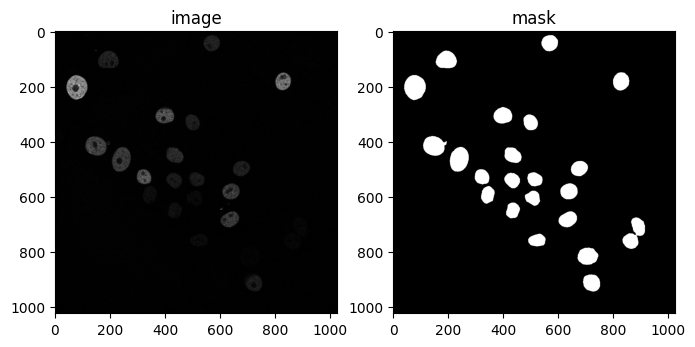

In [12]:
import matplotlib.pyplot as plt

img, m = dataset[0]
if img.ndim == 3 and img.shape[0] in (1,3):  # CHW -> HWC pour plt
    img_v = img.permute(1,2,0).cpu().numpy()
else:
    img_v = img.cpu().numpy()

m_v = m[0].cpu().numpy() if m.ndim == 3 else m.cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title('image'); plt.imshow(img_v, cmap='gray')
plt.subplot(1,2,2); plt.title('mask');  plt.imshow(m_v, cmap='gray')
plt.show()


TypeError: Invalid shape (1024,) for image data

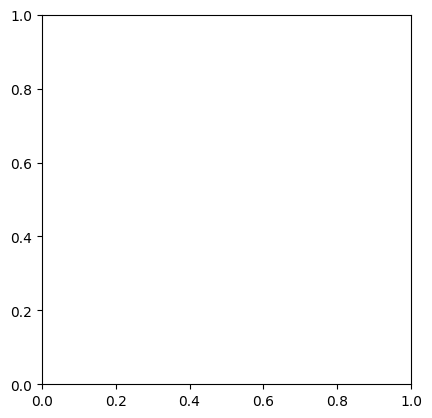

In [10]:
plt.imshow(im1[0,0].cpu(), cmap='gray')
plt.imshow(im1[0,0].cpu(), alpha=0.4)